# Symbolic Explanations on the Mutagenicity Dataset


### Load the packages, data and model

In [10]:
%load_ext autoreload
%autoreload 2

# import torch
# from symb_xai.model.gin import GIN
# import numpy as np

from symb_xai.visualization.plot_mutag import plot_molecule, plot_molecule_with_relevance, get_molecule_plot_info
from symb_xai.dataset.load_mutag import load_dataset
# from symb_xai.lrp.explain_mutag import lrp_gconv, lrp_linear
# from itertools import product
from tqdm import tqdm

from rdkit.Chem import Draw
from rdkit import Chem

dataset_name = 'Mutagenicity'
dataset = load_dataset(dataset_name)

import pandas as pd
substructures_df = pd.read_csv('data/Mutagenicity/Mutagenicity_substructure.csv', delimiter='&')

from symb_xai.model.mutag_utils import load_best_model
model = load_best_model('biasedMutagenicity') # _GIN_1731595245

debug = False
rule_linear = 'gamma'
gamma = 0.2
from symb_xai.dataset.load_mutag import get_substructure_match
from symb_xai.visualization.plot_mutag import plot_substructure_match
from symb_xai.lrp.symbolic_xai import MutagenicitySymbXAI
from symb_xai.utils import powerset
import matplotlib.pyplot as plt
from functools import reduce 

def find_substructure(molecule,substructure_name, substructures_df, plot=False):
    substructure_smarts = substructures_df[substructures_df['name']==substructure_name]['smarts'].values[0]
    substr_idx = get_substructure_match(molecule, substructure_smarts)
    if substr_idx is None:
        return False
    else: 
        if plot:
            print(substructure_name)
            plot_substructure_match(molecule, substr_idx)
        return {substructure_name: sorted(substr_idx)}
    

def obtatin_intersting_subtr_indices(interesting_substructures, molecule, substructures_df):
    mol_substructures = {}
    for substr_name in interesting_substructures: 
        substr_dict = find_substructure(molecule,substr_name , substructures_df, plot=False)
        if substr_dict:
            mol_substructures.update(substr_dict)

    # Aggregate all indices present in the dictionary
    all_indices = set(index for indices in mol_substructures.values() for index in indices)
    # Determine the missing indices
    missing_indices = set(range(molecule.GetNumAtoms())) - all_indices
    # Update the dictionary with the missing indices
    mol_substructures['rest'] = sorted(missing_indices)

    return mol_substructures, len(mol_substructures) == (len(interesting_substructures) +1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model biasedMutagenicity_GIN_1701953871.pth with test accuracy 0.8456


## search for some samples

In [11]:
substr_combination_names = [('Specific aromatic nitro', 'Sulfonamide'), ('Specific aromatic amine', 'Sulfonamide'), ('Specific aromatic nitro',), ('Specific aromatic amine',), ('Sulfonamide',) ]
all_considered_substructures = tuple(set(reduce (lambda x,y : x + y , substr_combination_names)))
print(all_considered_substructures)


mol_idx_by_substr_comb = {sc_name : [] for sc_name in substr_combination_names}

for idx in range(len(dataset)):
    sample = dataset[idx]
    plot_info = get_molecule_plot_info(sample, 
                                        dataset_name=dataset_name,
                                        info_list=['pos', 'node_label_dict', 'bond_type_dict'])
    molecule = plot_info['molecule']
    Chem.SanitizeMol(molecule)
    
    for substr_combination in substr_combination_names:
        substr_combination_compliment = tuple([name for name in all_considered_substructures if name not in substr_combination ])

        # Check if all substructures in the combination are found
        sub_combination_found = all(
            bool(find_substructure(molecule, substr_name, substructures_df, plot=False))
            for substr_name in substr_combination
        )

        # Check if all substructures in the complement are not found
        sub_combination_complement_not_found = all(
            not bool(find_substructure(molecule, substr_name, substructures_df, plot=False))
            for substr_name in substr_combination_compliment
        )

        # Combine the conditions in the if clause
        if sub_combination_found and sub_combination_complement_not_found:
            mol_idx_by_substr_comb[substr_combination].append(idx)
        
    # for substr_combination in substr_combination_names:
    #     if all([bool(find_substructure(molecule,substr_name , substructures_df, plot=False)) for substr_name in substr_combination]) and all([ not bool( find_substructure(molecule, substr_name, substructures_df, plot=False)) for substr_name in substr_combination_names_compliment ]):
    #             mol_idx_by_substr_comb[substr_combination].append(idx)




('Sulfonamide', 'Specific aromatic amine', 'Specific aromatic nitro')


In [12]:
for key, vals in mol_idx_by_substr_comb.items():
    print(key, len(vals))

('Specific aromatic nitro', 'Sulfonamide') 1
('Specific aromatic amine', 'Sulfonamide') 6
('Specific aromatic nitro',) 575
('Specific aromatic amine',) 331
('Sulfonamide',) 17


### Consider a specific molecule

In [13]:

import seaborn as sns
import pandas as pd
orange = (.8, 0.5, 0.0)
light_green = (0.5, .85, 0.5)
green = (0.0, 0.5, 0.0)

from symb_xai.visualization.utils import make_boxplots_with_stripplots



/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


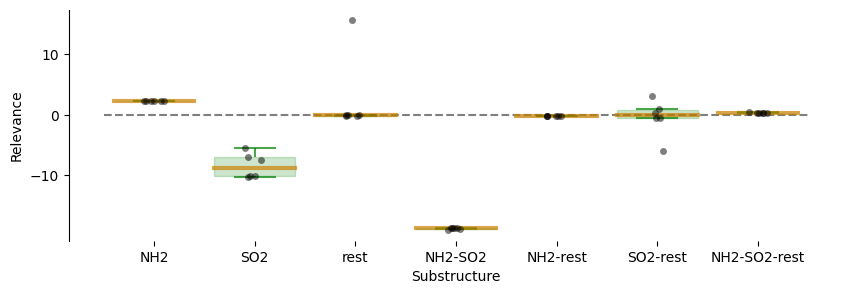

we skipted 0 samples from 6


/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


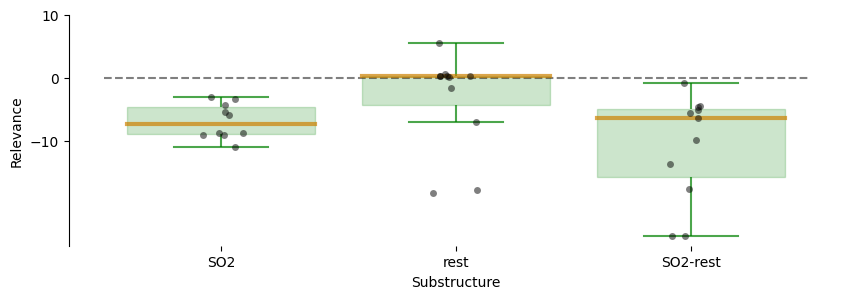

we skipted 0 samples from 17
not for 133
not for 815
not for 2138
not for 2471
not for 2925
not for 3349
not for 3556
not for 4019


/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


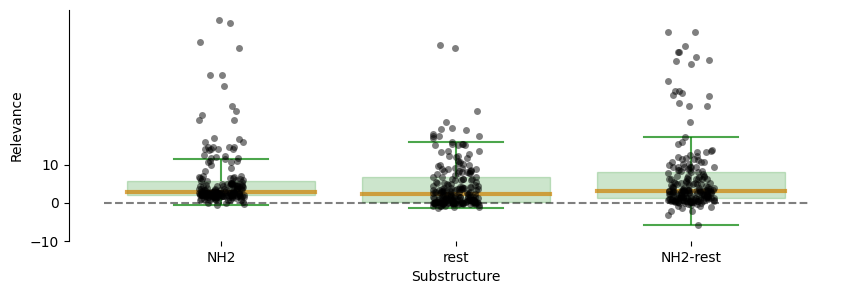

we skipted 8 samples from 331


In [14]:


plot_names = {
    'Specific aromatic nitro': 'NO2',
        'Specific aromatic amine': 'NH2',
        'Sulfonamide' : 'SO2', 
        'rest': 'rest'
    }

for interesting_substructures in [ ('Specific aromatic amine', 'Sulfonamide'), ('Sulfonamide',), ('Specific aromatic amine',), ]: #  # ['Specific aromatic nitro',  'Specific aromatic amine', 'Sulfonamide', ]
    if interesting_substructures == ('Specific aromatic amine', 'Sulfonamide'):
        observed_class = 1
        plot_extent='SO2_NH2'
    elif interesting_substructures == ('Specific aromatic amine',):
        observed_class = 0
        plot_extent = 'NH2'
    elif interesting_substructures == ('Sulfonamide',):
        observed_class = 1
        plot_extent = 'SO2'
    else:
        raise NotImplementedError

    intersting_indices = mol_idx_by_substr_comb[interesting_substructures] # [428, 262, 834, 1552, 1639, 2951, 3561] # [67,283,910,1064,1228,1248,1692,1832,1890,2072,2373,2621,3103,3286,3724,4063,4322 ]
    
    plot_samples = [] #range(len(dataset)) #[]

    ######### 
    
    nbs_of_errors = 0
    all_rels = {}
    for idx in intersting_indices:
        sample = dataset[idx]
        if sample.x.shape[0] != len(set(sample.edge_index[0].numpy())): # This is just a dataspecific bug
            print('not for', idx)
            nbs_of_errors += 1
            continue
        plot_info = get_molecule_plot_info(sample, 
                                            dataset_name=dataset_name,
                                            info_list=['pos', 'node_label_dict', 'bond_type_dict'])
        molecule = plot_info['molecule']
        Chem.SanitizeMol(molecule)
        

        if model(sample.x, sample.edge_index).argmax() != sample.y:
            continue
        if observed_class is not None and sample.y != observed_class:
            continue
        

        mol_substructures, _  = obtatin_intersting_subtr_indices(interesting_substructures, molecule, substructures_df)
        
        explainer = MutagenicitySymbXAI(sample,
                            model,
                            gamma=0.1,
                            scal_val=1.,
                            target_class= None,
                            debug = False)

        substr_pset = powerset(mol_substructures.keys())

        for i, subst_names in enumerate(substr_pset):
            curr_substrs = [mol_substructures[name] for name in subst_names]
            rel = explainer.harsanyi_div(curr_substrs)
            reduc_name = reduce(lambda x,y: x + '-' + y, [plot_names[name] for name in subst_names] )
            
            # print(subst_names, rel, reduc_name)
            if reduc_name in all_rels.keys():
                all_rels[reduc_name] += [rel]
            else:
                all_rels[reduc_name] = [rel]

        if idx in plot_samples:
            display(Draw.MolToImage(molecule))
            plt.figure(figsize=(15,2))
            plt.bar( all_rels.keys() ,
                    [rels[-1] for rels in all_rels.values()],
                    color=['red' if rels[-1]>0 else 'blue' for rels in all_rels.values()])
            plt.show()
            print('prediction is:', 'non-mutagenic' if  1 == model(sample.x, sample.edge_index).argmax() else 'mutagenic',  model(sample.x, sample.edge_index).detach().numpy())
            print('ground-truth is:', 'non-mutagenic' if  1 == sample.y else 'mutagenic') 

    # fig, ax = plt.subplots(figsize=(10,4))
    

    # Assuming 'all_rels' is your dictionary of data
    data = []
    for key, values in all_rels.items():
        for value in values:
            data.append({'Substructure': key, 'Relevance': value.item()})
    # Convert to DataFrame
        
    make_boxplots_with_stripplots(data, plot_extent=plot_extent)
    print('we skipted', nbs_of_errors, 'samples from', len(intersting_indices))

## Explaining queries

In [15]:

from symb_xai.utils import Query_from_promt



# promt = 'NH2 IMPLIES SO2'
# concept2index_set = {'NH2': [1,2,3,4], 'SO2': [5,6,7,8]}

# # query = query_promt2lamb_fct(promt=promt,
# #                      concept2index_set=concept2index_set)

# for s in [[1], [5], [1,5], [9]]:
#     print(s,query(s))

In [16]:
# from itertools import product
from functools import reduce
from copy import copy


import re

from symb_xai.query_search.utils import generate_promts



all_concepts = ['NH2', 'SO2', 'rest']
all_promts = copy(all_concepts)


all_promts += generate_promts(all_input_promts=all_concepts,
                modes=[
                    'negation of promts'
                ])

all_promts = generate_promts(all_input_promts=all_promts,
            modes=[
                f'conjuction of order {order} between promts'  for order in range(1,4)
            ])

# all_promts = generate_promts(all_input_promts=all_concepts,
#                              modes=[
#                                  'implication between promts'
#                              ])

# all_promts = generate_promts(all_input_promts=all_promts,
#                              more_input_promts=all_concepts,
#                              modes=[
#                                  'conjoin different promts with each other'
#                              ])

all_promts

['NH2',
 'SO2',
 'rest',
 'NOT NH2',
 'NOT SO2',
 'NOT rest',
 'NH2 AND SO2',
 'NH2 AND rest',
 'NH2 AND NOT SO2',
 'NH2 AND NOT rest',
 'SO2 AND rest',
 'SO2 AND NOT NH2',
 'SO2 AND NOT rest',
 'rest AND NOT NH2',
 'rest AND NOT SO2',
 'NH2 AND SO2 AND rest',
 'NH2 AND SO2 AND NOT rest',
 'NH2 AND rest AND NOT SO2',
 'SO2 AND rest AND NOT NH2']

/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


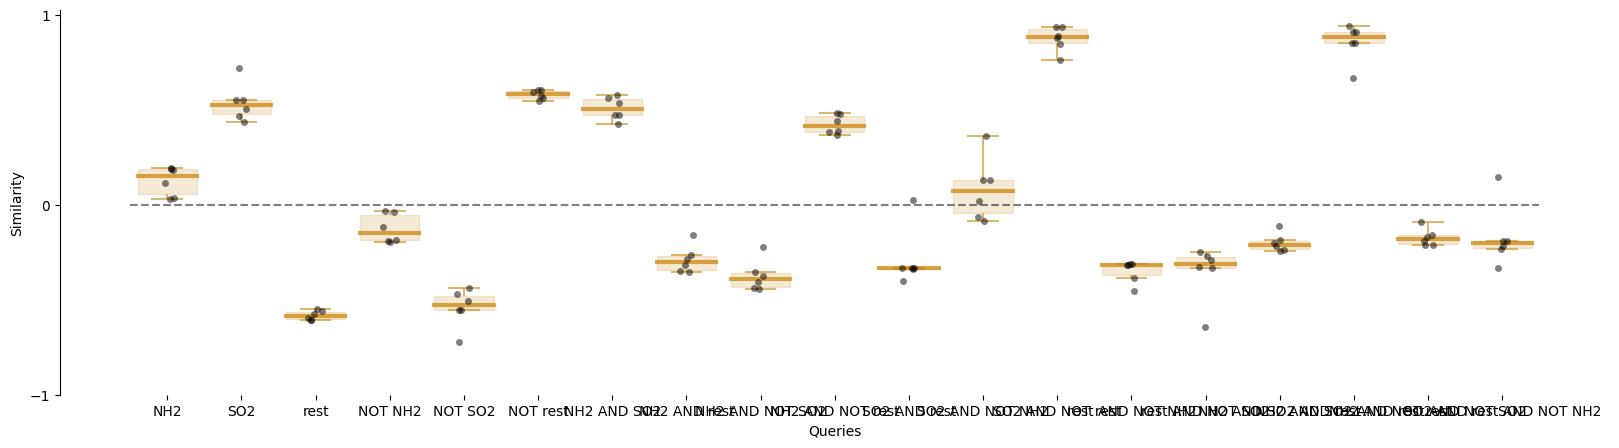

In [17]:
import numpy as np
from symb_xai.query_search.utils import corr 
interesting_substructures = ('Specific aromatic amine', 'Sulfonamide')
all_query_promts = all_promts #['NH2 AND SO2', 'NH2 AND NOT SO2', 'NOT NH2 AND SO2', 'NH2 AND rest', 'SO2 AND rest', 'SO2 IMPLIES NH2', 'NH2 IMPLIES SO2', 'SO2', 'SO2 AND NOT rest', '( NH2 IMPLIES SO2 ) AND NOT rest']

plot_samples = False 
plot_extent = 'queries_NH2_SO2'

result_mode =  'Similarity' #  'Relevance' 

concept_names = {
    'Specific aromatic nitro': 'NO2',
    'Specific aromatic amine': 'NH2',
    'Sulfonamide' : 'SO2', 
    'rest': 'rest'
}

query_attributions = {promt: [] for promt in all_query_promts}
filter_vectors = {}
multi_order_vectors = {}
for idx in mol_idx_by_substr_comb[interesting_substructures]:
    for query_promt in all_query_promts:

        sample = dataset[idx]

        plot_info = get_molecule_plot_info(sample, 
                                            dataset_name=dataset_name,
                                            info_list=['pos', 'node_label_dict', 'bond_type_dict'])

        molecule = plot_info['molecule']
        Chem.SanitizeMol(molecule)

        mol_substructures, success  = obtatin_intersting_subtr_indices(interesting_substructures, molecule, substructures_df)

        if not success: print('something went wrong here')

        explainer = MutagenicitySymbXAI(sample,
                                    model,
                                    gamma=0.1,
                                    scal_val=1.,
                                    target_class= None,
                                    debug = False)

        substr_pset = powerset(mol_substructures.keys())

        concept2ids = {concept_names[concept]: subset for concept, subset in mol_substructures.items()}

        query = Query_from_promt(
            promt=query_promt,
            concept2ids=concept2ids, 
            str_rep=None
        )
        
        filter_vector = []
        multi_order_vector = []
        for i, subst_names in enumerate(substr_pset):
            curr_substrs = [mol_substructures[name] for name in subst_names]
            # save the multi order term
            multi_order_vector.append(explainer.harsanyi_div(curr_substrs))

            # save the query output
            concat_subsets = reduce(lambda x,y: x+y, curr_substrs)
            filter_vector.append(int(query(tuple(concat_subsets))))
        
        multi_order_vectors[query_promt] = multi_order_vector
        filter_vectors[query_promt]= filter_vector


        # rel = 0.
        # for i, subst_names in enumerate(substr_pset):
        #     curr_substrs = [mol_substructures[name] for name in subst_names]
        #     # print(subst_names, query(tuple([concept_names[name] for name in subst_names])))
        #     hars = explainer.harsanyi_div(curr_substrs)
            
        #     # print(concat_subsets)
        #     if query(tuple(concat_subsets)):
        #         rel += hars

        if result_mode == 'Relevance':
            query_attributions[query_promt] += [np.dot(filter_vector,multi_order_vector)]
            plot_color = (0.5, 0.0, 0.5) 
            yticks=[10,0,-10]
        elif result_mode == 'Similarity':
            query_attributions[query_promt] += [corr(np.array(filter_vector),-np.array(multi_order_vector))]
            plot_color = (0.8, .6, 0.2)
            yticks = [1,0,-1]
        else:
            raise ValueError(f'result_mode = {result_mode} is not a valid input.')

    if plot_samples:
        display(Draw.MolToImage(molecule))
        plt.figure(figsize=(15,2))
        plt.bar( query_attributions.keys() ,
                        [rels[-1] for rels in query_attributions.values()],
                        color=['red' if rels[-1]>0 else 'blue' for rels in query_attributions.values()])
        plt.show()

data = []
for key, values in query_attributions.items():
    for value in values:
        data.append({'Queries': key, result_mode: value})
# Convert to DataFrame
 
make_boxplots_with_stripplots(data, 
             plot_extent=plot_extent, 
             figsize=(20,5), 
             boxcolor=plot_color,
             outlier_quantile=0,
             yticks = yticks)


In [18]:
# substr_pset,filter_vectors, 2**7
mol_substructures
# NH2, SO2, rest, NH2 AND SO2,... NH2 AND SO2 AND rest, ..., NOT NH2, ... NOT NH2 AND SO2,... ---> A IMPLIES B, ( A IMPLIES B ) AND C 

{'Specific aromatic amine': [2, 3, 7, 8, 10, 13, 21, 22],
 'Sulfonamide': [0, 1, 4, 5, 6, 9],
 'rest': [11, 12, 14, 15, 16, 17, 18, 19, 20, 23, 24]}

## Consider conservation property 

not for 38
not for 133
not for 166
not for 171
not for 220
not for 246
not for 268
not for 278
not for 286
not for 296
not for 302
not for 305
not for 309
not for 339
not for 357
not for 439
not for 470
not for 497
not for 527
not for 706
not for 743
not for 783
not for 815
not for 861
not for 878
not for 902
not for 918
not for 1029
not for 1040
not for 1044
not for 1057
not for 1085
not for 1193
not for 1233
not for 1329
not for 1394
not for 1431
not for 1525
not for 1528
not for 1532
not for 1609
not for 1645
not for 1696
not for 1915
not for 1971
not for 2024
not for 2026
not for 2036
not for 2069
not for 2133
not for 2138
not for 2142
not for 2143
not for 2174
not for 2193
not for 2210
not for 2234
not for 2258
not for 2360
not for 2422
not for 2440
not for 2471
not for 2482
not for 2483
not for 2503
not for 2553
not for 2559
not for 2604
not for 2627
not for 2673
not for 2687
not for 2720
not for 2738
not for 2808
not for 2824
not for 2878
not for 2925
not for 2959
not for 3012
n

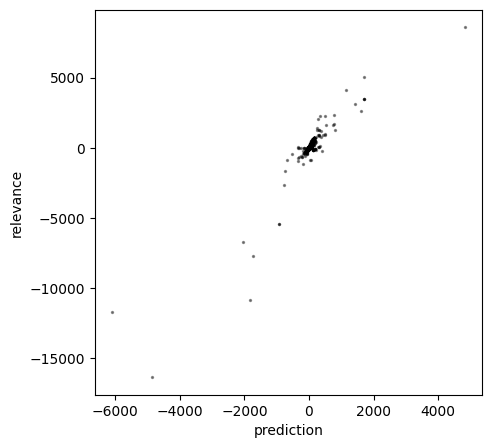

In [19]:
rels, preds = [], []
nbs = 0
for idx, sample in enumerate(dataset):
    
    if sample.x.shape[0] != len(set(sample.edge_index[0].numpy())):
        print('not for', idx)
        nbs += 1
        continue
    explainer = MutagenicitySymbXAI(sample,
                        model,
                        gamma=0.1,
                        scal_val=1.,
                        target_class= None,
                        debug = False)
    # except Exception as e:
    #     print('not for', idx)
    #     print(e)
    
    rels.append(explainer.subgraph_relevance(explainer.node_domain))
    pred = model(sample.x, sample.edge_index).detach()
    preds.append(pred[0] - pred[1])

plt.figure(figsize=(5,5))
plt.scatter(preds,rels, c='black', s= 2, alpha=.4)
plt.ylabel('relevance')
plt.xlabel('prediction')
plt.show()